In [1]:
import pandas as pd
from scipy.spatial.distance import cosine
from scipy import stats
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt

In [2]:
# C:/Users/Lenovo/Desktop/EnergyBERT/mat_bert_cased
# bert-cased
tokenizer = BertTokenizer.from_pretrained('C:/Users/Lenovo/Desktop/EnergyBERT/mat_bert_cased', do_lower_case=False)
model = BertModel.from_pretrained('C:/Users/Lenovo/Desktop/EnergyBERT/mat_bert_cased', output_hidden_states=True).eval()

Some weights of the model checkpoint at C:/Users/Lenovo/Desktop/EnergyBERT/mat_bert_cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at C:/Users/Lenovo/Desktop/EnergyBERT/mat_bert_cased and are newly initialized

In [19]:
def get_embedding(text, tokenizer, model):
    tokenized_text = tokenizer.tokenize(text)
    need_idx = []
    for i in range(len(tokenized_text)):
        need_idx.append(i)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    with torch.no_grad():
        outputs = model(tokens_tensor)
        # hidden_states has 4 dimensions: 13 layer, 1 batch, x token number, 768 hidden unit
        hidden_states = outputs[2]
    token_embeddings = torch.stack(hidden_states, dim=0)
    # remove batch dimension
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    # size: x token, 13 layer, 768 hidden unit
    token_embeddings = token_embeddings.permute(1,0,2)
    token_vecs_sum = []
    for token in token_embeddings:
        # last 4 layer
        sum_vec = torch.sum(token[2:3], dim=0)
        # sum_vec: [768]
        token_vecs_sum.append(sum_vec)
    embeddings = []
    for i in need_idx:
        embeddings.append(token_vecs_sum[i])
    sentence_embedding = torch.mean(torch.stack(embeddings), 0)
    return sentence_embedding

In [20]:
file_path = 'for_spearman/'
file_name = 'zt_ori_84.txt'

In [21]:
df = pd.read_csv(file_path+file_name, sep='\t', header=None, names=['name', 'value'])

In [24]:
thermoelectric_embedding = get_embedding("thermoelectric", tokenizer, model) # thermoelectric

In [25]:
from tqdm import tqdm
record = {}
for i, n in enumerate(df['name']):
    similarity = 1 - cosine(get_embedding(n, tokenizer, model), thermoelectric_embedding)
    token_num = len(tokenizer.tokenize(n))
    record[n] = {}
    record[n]['sim'] = similarity
    record[n]['token_num'] = token_num
    record[n]['thermo_rank'] = i+1

In [26]:
sorted_record = sorted(record.items(), key=lambda item:item[1]['sim'], reverse=True)
for_comparison = [i+1 for i in range(len(df['name']))]
comparison = []
for n in df['name']:
    for i, x in enumerate(sorted_record):
        if n == x[0]:
            comparison.append(i+1)
            record[n]['sim_rank'] = i+1
print(sorted_record[:5])

[('Bi2Te3', {'sim': 0.7727129459381104, 'token_num': 1, 'thermo_rank': 15, 'sim_rank': 1}), ('In2O3', {'sim': 0.6307909488677979, 'token_num': 1, 'thermo_rank': 59, 'sim_rank': 2}), ('Sb2Te3', {'sim': 0.6212441325187683, 'token_num': 2, 'thermo_rank': 42, 'sim_rank': 3}), ('ZnO', {'sim': 0.5863296389579773, 'token_num': 1, 'thermo_rank': 82, 'sim_rank': 4}), ('LaCoO3', {'sim': 0.5468387007713318, 'token_num': 2, 'thermo_rank': 83, 'sim_rank': 5})]


In [27]:
res = stats.spearmanr(for_comparison, comparison)
print(res)

SpearmanrResult(correlation=0.17071985420674296, pvalue=0.12050663789897764)


In [28]:
sim_rank = []
token_num = []
for i in record.keys():
    sim_rank.append(record[i]['sim_rank'])
    token_num.append(record[i]['token_num'])
print(sim_rank)
print(token_num)
res = stats.spearmanr(sim_rank, token_num)
print(res)

[9, 15, 43, 82, 8, 52, 37, 25, 38, 51, 24, 19, 56, 44, 1, 20, 53, 62, 45, 80, 55, 12, 57, 33, 10, 16, 46, 42, 11, 17, 65, 36, 22, 21, 30, 84, 63, 81, 74, 23, 64, 3, 27, 41, 35, 68, 32, 47, 7, 50, 76, 58, 28, 61, 18, 60, 83, 75, 2, 6, 79, 73, 31, 66, 29, 54, 39, 72, 49, 77, 40, 71, 34, 26, 70, 13, 78, 14, 48, 59, 67, 4, 5, 69]
[2, 7, 13, 6, 2, 9, 7, 8, 4, 13, 4, 5, 3, 5, 1, 3, 4, 10, 7, 9, 9, 5, 8, 5, 5, 5, 10, 9, 2, 3, 6, 3, 13, 9, 9, 10, 10, 7, 7, 10, 7, 2, 9, 9, 10, 9, 9, 10, 3, 7, 10, 4, 6, 10, 4, 3, 10, 7, 1, 4, 5, 5, 7, 10, 7, 6, 10, 10, 9, 10, 3, 5, 7, 4, 10, 5, 4, 8, 9, 3, 8, 1, 2, 7]
SpearmanrResult(correlation=0.4605319116529, pvalue=1.0435685223274476e-05)


In [165]:
for_comparison = []
comparison = []
for i in record.keys():
    if record[i]['token_num'] < 4:
        for_comparison.append(record[i]['thermo_rank'])
        comparison.append(record[i]['sim_rank'])
print(len(comparison))
res = stats.spearmanr(for_comparison, comparison)
print(res)

16
SpearmanrResult(correlation=0.3529411764705882, pvalue=0.17995865788498183)


In [135]:
import json

json_str = json.dumps(record, indent=4)
with open('zt_84_bert.json', 'w', encoding='utf-8') as json_file:
    json_file.write(json_str)

# bert & matbert tokenizer comparison

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]


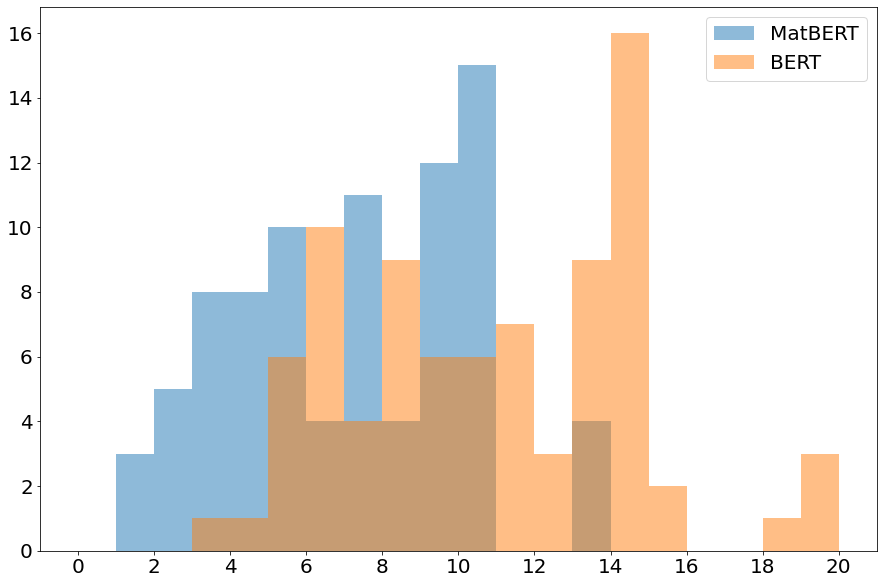

In [459]:
import numpy
tmp_list_bert = []
tmp_list_matbert = []
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
matbert_tokenizer = BertTokenizer.from_pretrained('C:/Users/Lenovo/Desktop/EnergyBERT/mat_bert_cased', do_lower_case=False)
for n in df['name']:
    tokenized_text = bert_tokenizer.tokenize(n)    
    tmp_list_bert.append(len(tokenized_text))
    tokenized_text = matbert_tokenizer.tokenize(n)
    tmp_list_matbert.append(len(tokenized_text))
    
bins = numpy.linspace(0, 20, 21, endpoint=True)
print(bins)
plt.figure(figsize=(15,10))
plt.hist(tmp_list_matbert, bins, alpha=0.5, label='MatBERT')
plt.hist(tmp_list_bert, bins, alpha=0.5, label='BERT')
# plt.margins(0.1, 0.1)
plt.legend(loc='upper right', fontsize="20")
x = range(0,22,2)
plt.xticks(x)
plt.tick_params(labelsize=20)
plt.savefig('_idx.png',dpi=300)
plt.show()

# experimental results & token correlation

In [167]:
for_comparison = []
comparison = []
for i in record.keys():
    for_comparison.append(record[i]['thermo_rank'])
    comparison.append(record[i]['token_num'])

res = stats.spearmanr(for_comparison, comparison)
print(res)

SpearmanrResult(correlation=0.015477920774031265, pvalue=0.888865214941374)
